# **Analysing CoronaCentral Search Logs**






In this notebook I will be analysing the queries taken from the search logs of CoronaCentral, comparing them to the queries provided in TREC-COVID.


# **Setup**

In [1]:
import json
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, HTML

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
!pip install --upgrade python-terrier

     |████████████████████████████████| 97 kB 2.6 MB/s 
     |████████████████████████████████| 1.1 MB 16.2 MB/s 
     |████████████████████████████████| 69 kB 6.2 MB/s 
     |████████████████████████████████| 255 kB 28.0 MB/s 
     |████████████████████████████████| 41 kB 220 kB/s 
     |████████████████████████████████| 596 kB 42.1 MB/s 
     |████████████████████████████████| 294 kB 11.3 MB/s 
     |████████████████████████████████| 1.2 MB 40.0 MB/s 
     |████████████████████████████████| 126 kB 43.1 MB/s 
     |████████████████████████████████| 72 kB 1.3 MB/s 
     |████████████████████████████████| 6.4 MB 29.4 MB/s 
     |████████████████████████████████| 291 kB 47.3 MB/s 
     |████████████████████████████████| 59 kB 3.5 MB/s 
     |████████████████████████████████| 45 kB 2.5 MB/s 
  Created wheel for python-terrier: filename=python_terrier-0.8.0-py3-none-any.whl size=103883 sha256=8c64dae63badbb67550af27cda695820e453ac711197b1b4e1af5f799dfdc5b2
  Stored in directory: /root/.cac

In [3]:
import pyterrier as pt

if not pt.started():
  pt.init()

terrier-assemblies 5.6 jar-with-dependencies not found, downloading to /root/.pyterrier...
Done
terrier-python-helper 0.0.6 jar not found, downloading to /root/.pyterrier...
Done


PyTerrier 0.8.0 has loaded Terrier 5.6 (built by craigmacdonald on 2021-09-17 13:27)



In [4]:
cord19 = pt.datasets.get_dataset('irds:cord19/trec-covid')
topics = cord19.get_topics()
qrels = cord19.get_qrels()

[INFO] [starting] https://ir.nist.gov/covidSubmit/data/topics-rnd5.xml
[INFO] [finished] https://ir.nist.gov/covidSubmit/data/topics-rnd5.xml: [00:00] [18.7kB] [8.35MB/s]
[INFO] [starting] https://ir.nist.gov/covidSubmit/data/qrels-covid_d5_j0.5-5.txt


There are multiple query fields available: ('title', 'description', 'narrative'). To use with pyterrier, provide variant or modify dataframe to add query column.


[INFO] [finished] https://ir.nist.gov/covidSubmit/data/qrels-covid_d5_j0.5-5.txt: [00:01] [1.14MB] [834kB/s]


In [5]:
!wget https://raw.githubusercontent.com/DavidONeill75101/level-4-project/master/Datasets/coronacentral_log.csv

--2022-03-16 16:52:33--  https://raw.githubusercontent.com/DavidONeill75101/level-4-project/master/Datasets/coronacentral_log.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 111379 (109K) [text/plain]
Saving to: ‘coronacentral_log.csv’

coronacentral_log.c 100%[===================>] 108.77K  --.-KB/s    in 0.03s   

2022-03-16 16:52:33 (3.20 MB/s) - ‘coronacentral_log.csv’ saved [111379/111379]



In [6]:
lines = []

logs = pd.read_csv('/content/coronacentral_log.csv')
logs = logs.sort_values(by='Pageviews', ascending=False)

topic_list = []
page_list = logs['Page']
for topic in page_list:
  last_instance = topic.rindex('/')
  topic_list.append(topic[last_instance+1:])

most_viewed_pages = logs['Page']
number_views = logs['Pageviews']
number_unique_views = logs['Unique Pageviews']

# **Top 20 Most Searched Topics on CoronaCentral**

In [7]:
top_20 = list(most_viewed_pages[:20])
new_top_20 = []

for topic in top_20:
  last_instance = topic.rindex('/')
  new_top_20.append(topic[last_instance+1:])

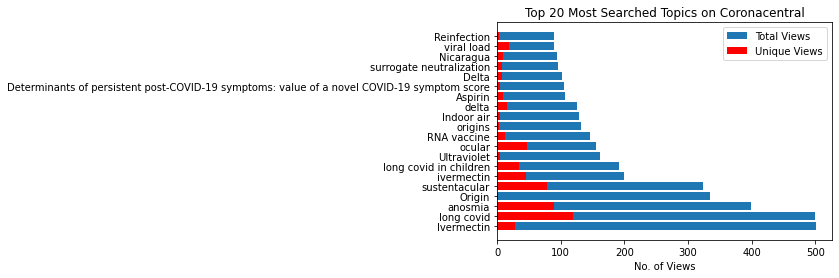

In [8]:
plt.barh(new_top_20, number_views[:20], label="Total Views")
plt.barh(new_top_20, number_unique_views[:20], color='red', label="Unique Views")
plt.title("Top 20 Most Searched Topics on Coronacentral")
plt.xlabel("No. of Views")
plt.legend()

# **Classifying Queries**

In [9]:
!wget https://github.com/DavidONeill75101/level-4-project/blob/master/Datasets/coronacentral_with_altmetric.json.gz?raw=true

--2022-03-16 16:52:34--  https://github.com/DavidONeill75101/level-4-project/blob/master/Datasets/coronacentral_with_altmetric.json.gz?raw=true
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/DavidONeill75101/level-4-project/raw/master/Datasets/coronacentral_with_altmetric.json.gz [following]
--2022-03-16 16:52:34--  https://github.com/DavidONeill75101/level-4-project/raw/master/Datasets/coronacentral_with_altmetric.json.gz
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/DavidONeill75101/level-4-project/master/Datasets/coronacentral_with_altmetric.json.gz [following]
--2022-03-16 16:52:34--  https://media.githubusercontent.com/media/DavidONeill75101/level-4-project/master/Datasets/coronacentral_with_altmetric.json.gz
Resolving media.githu

In [10]:
import gzip
import pandas as pd

with gzip.open('/content/coronacentral_with_altmetric.json.gz?raw=true', 'r') as f:
  cc = f.read()

import json

json_str = cc.decode('utf-8')            
data = json.loads(json_str)     

coronacentral = pd.DataFrame.from_dict(data)

In [11]:
qrels = qrels[qrels['label']>0]

In [12]:
X_train = list(cord19.get_topics('title')['query'])

y_train = []


for i in range(1, 51):
  specific_qrels = qrels[qrels['qid']==str(i)]
  specific_docs = coronacentral[coronacentral['cord_uid'].isin(specific_qrels['docno'])]
  specific_topics = specific_docs['topics']
  unique_topics = np.unique(np.array(sum(list(specific_topics), [])))
  y_train.append(list(unique_topics))

/usr/local/lib/python3.7/dist-packages/pyterrier/datasets.py:433: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df.drop(df.columns.difference(['qid','query']), 1, inplace=True)


In [13]:
mlb = MultiLabelBinarizer()
y_train_to_use = mlb.fit_transform(y_train)

In [14]:
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words='english')),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])

LogReg_pipeline.fit(X_train, y_train_to_use)

Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words='english')),
                ('clf',
                 OneVsRestClassifier(estimator=LogisticRegression(solver='sag'),
                                     n_jobs=1))])

In [15]:
prediction = LogReg_pipeline.predict(np.array(topic_list))

In [22]:
counts = dict.fromkeys(mlb.classes_, 0)
for x, line in zip(topic_list, prediction):
  
  one_indexes = np.where(line==1)
  classes = mlb.classes_[one_indexes]
  for clas in mlb.classes_:
    if clas in classes:
      counts[clas]+=1

Text(0, 0.5, 'Category')

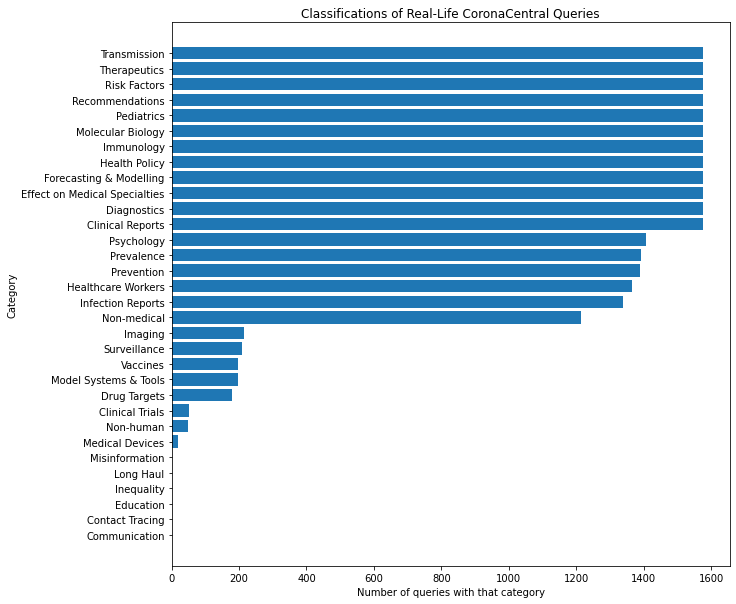

In [23]:
counts = {k: v for k, v in sorted(counts.items(), key=lambda item: item[1])}

plt.figure(figsize=(10, 10))

plt.barh(list(counts.keys()), list(counts.values()))
plt.title("Classifications of Real-Life CoronaCentral Queries")
plt.xlabel("Number of queries with that category")
plt.ylabel("Category")

In [20]:
counts2 = dict.fromkeys(mlb.classes_, 0)
for line in y_train:
  for clas in mlb.classes_:
    if clas in line:
      counts2[clas]+=1

Text(0, 0.5, 'Category')

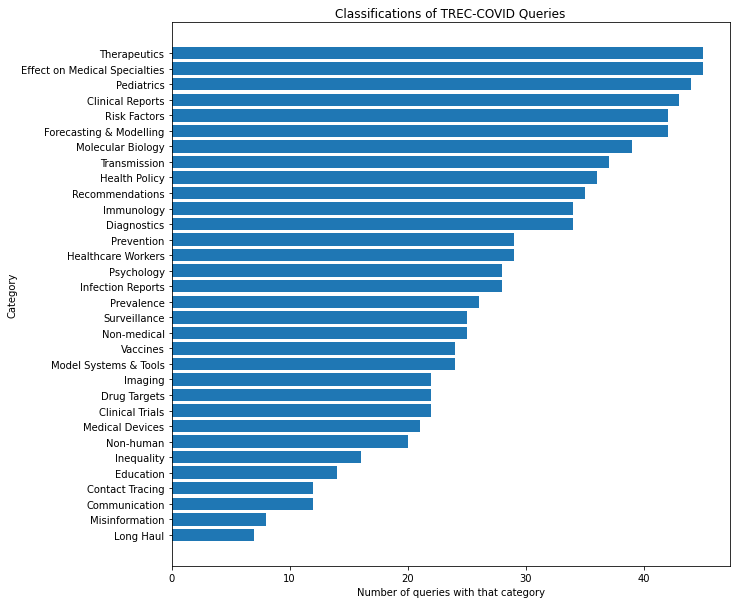

In [21]:
counts2 = {k: v for k, v in sorted(counts2.items(), key=lambda item: item[1])}

plt.figure(figsize=(10, 10))

plt.barh(list(counts2.keys()), list(counts2.values()))
plt.title("Classifications of TREC-COVID Queries")
plt.xlabel("Number of queries with that category")
plt.ylabel("Category")

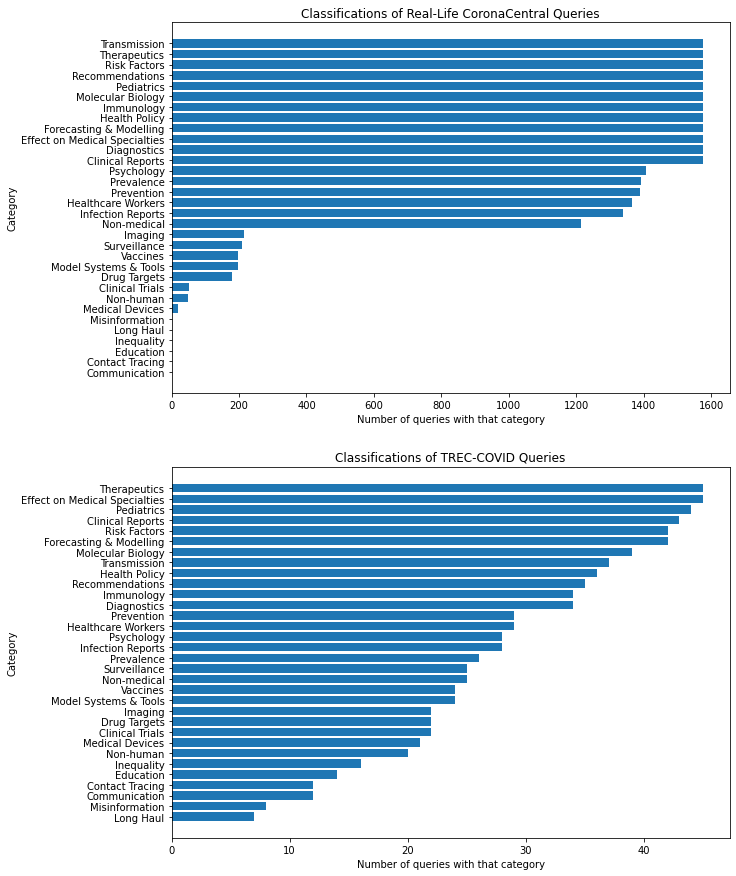

In [37]:
fig, ax = plt.subplots(2, figsize=(10,15))

ax[0].barh(list(counts.keys()), list(counts.values()))
ax[0].set_title("Classifications of Real-Life CoronaCentral Queries")
ax[0].set_xlabel("Number of queries with that category")
ax[0].set_ylabel("Category")

ax[1].barh(list(counts2.keys()), list(counts2.values()))
ax[1].set_title("Classifications of TREC-COVID Queries")
ax[1].set_xlabel("Number of queries with that category")
ax[1].set_ylabel("Category")

plt.savefig("query_comparison.pdf", format="pdf", bbox_inches="tight") 